<a href="https://colab.research.google.com/github/jbarsce/AprendizajePorRefuerzos/blob/master/lab_1_intro_rl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 1: Introducción al aprendizaje por refuerzos

**Marcelo Fullana Yornet y Araceli Acosta**

Curso Aprendizaje por Refuerzos, Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

FaMAF, 2024

# Introducción

En el siguiente notebook se muestra cómo ejecutar agentes de aprendizaje por refuerzos, los cuáles son necesarios para realizar este Lab.

### Repaso rápido



* Recompensa: señal $r$ recibida desde el entorno que recompensa o castiga el agente según su desempeño con respecto al objetivo de la tarea.

* Valor: función $v_\pi (s)$ que establece cuánto el agente espera percibir de recompensa al seguir la política $\pi$ partiendo desde el estado $s$. También se la suele expresar como $Q_\pi(s,a)$, indicando cuánto el agente espera percibir siguiendo la política $\pi$ partiendo desde el estado $s$ y siguiendo la acción $a$.

* Política: función $\pi(s) \to a$ que mapea un estado a una acción. Se suele expresar como probabilidad de elegir la acción $\pi(a \mid s)$. La política $\epsilon$-greedy, en donde $\epsilon$ es la probabilidad de exploración (normalmente menor que la probabilidad de explotación) está dada por $\pi(a \mid s) = 1 - \epsilon$ si $a$ es la mejor acción, caso contrario pasa a estar dada por $\pi(a \mid s) = \epsilon$.

Por otra parte, en la política Softmax, no se busca la acción con máxima probabilidad sino que se computa la probabilidad de cada una mediante la función Softmax y se realiza un sorteo entre ellas pesado por la misma. Así, para cada acción $a$, $$\pi(a \mid s) = \frac{e^{Q(s,a)/\tau}}{\sum_{\widetilde{a} \in A}e^{Q(s,\widetilde{a})/\tau}}$$

En este notebook vemos dos algoritmos para actualizar la función de valor (y, por lo tanto, la política de selección de acciones):

* Actualización por SARSA (on-policy).

$$Q(s,a) \gets Q(s,a) + \alpha (r + \gamma Q(s',a') - Q(s,a))$$

Algoritmo completo (a modo de referencia):

![Algoritmo SARSA](https://github.com/DiploDatos/AprendizajePorRefuerzos/blob/master/images/sarsa.png?raw=1)


* Actualización por Q-Learning (off-policy)

$$Q(s,a) \gets Q(s,a) + \alpha (r + \gamma \arg\max_{a'} Q(s',a') - Q(s,a))$$

Algoritmo completo (a modo de referencia):

![Algoritmo Q-Learning](https://github.com/DiploDatos/AprendizajePorRefuerzos/blob/master/images/q_learning.png?raw=1)

Fuente de las imágenes: capítulo 6 de [Reinforcement Learning: An Introduction](http://www.incompleteideas.net/book/the-book.html).

## Librería a usar: Librería OpenAI Gym

[OpenAI Gym](https://gym.openai.com/) (Brockman et. al., 2016) es una librería de OpenAI que ofrece entornos y una interfaz estándar con la cuál probar nuestros agentes. Su objetivo es proveer benchmarks unificados para ver el desempeño de algoritmos en el entorno y así poder saber con facilidad cómo es su desempeño comparado con los demás. Parte de la siguiente sección está basada en la [documentación oficial de OpenAI](https://gym.openai.com/docs/).

La interfaz principal de los ambientes de gym es la interfaz Env. La misma posee cinco métodos principales:

* ```reset(self, seed)``` : Reinicia el estado del entorno, a su estado inicial, devolviendo una observación de dicho estado. Opcionalmente, establece la semilla aleatoria del generador de números aleatorios del presente entorno.

* ```step(self, action)``` : "Avanza" un timestep del ambiente. Devuelve: ```observation, reward, terminated, truncated, info```.

* ```render(self)``` : Muestra en pantalla una parte del ambiente.

* ```close(self)``` : Finaliza con la instancia del agente.


Por otra parte, cada entorno posee los siguientes tres atributos principales:

* ```action_space``` : El objeto de tipo Space correspondiente al espacio de acciones válidas.

* ```observation_space``` : El objeto de tipo Space correspondiente a todos los rangos posibles de observaciones.

* ```reward_range``` : Tupla que contiene los valores mínimo y máximo de recompensa posible.

Algunas de las ejecuciones contienen videos. Para poder verlos se necesita previamente instalar la librería ffmpeg; para instalarla desde Linux ejecutar en consola

```apt-get install ffmpeg```

desde Mac, reemplazar *apt-get* por *brew*

desde Windows, descargarla desde

[https://ffmpeg.org/download.html](https://ffmpeg.org/download.html)

(Nota: las animaciones son a modo ilustrativo, si no se desea instalar la librería se puede directamente eliminar la línea de código donde se llama al método ``env.render(mode='human')``)

Código básico de importación y funciones de graficación (no modificar)

A continuacion se armaran funciones para visualizar datos relacionados con un agente en Aprendizaje por Refuerzo.

1)  plot_reward_per_episode:

    Toma una lista de recompensas por episodio reward_ep.
    Calcula la recompensa acumulada media por episodio, suavizando la curva de recompensas mediante el cálculo de un promedio acumulativo de recompensas a lo largo de los episodios.
    Genera un gráfico mostrando la recompensa acumulada por episodio, que ayuda a visualizar la convergencia de la política del agente.     

2)  plot_steps_per_episode:

    Toma una lista timesteps_ep de pasos (timesteps) por episodio.
    Grafica el número de pasos en cada episodio, lo que permite analizar el progreso del agente en términos de eficiencia (si el número de pasos disminuye, el agente está mejorando en alcanzar su objetivo más rápidamente).

3)  plot_steps_per_episode_smooth:

    Similar a la función anterior, toma timesteps_ep y grafica una versión suavizada del número de pasos por episodio.
    Calcula la media acumulada de pasos para cada episodio, lo cual suaviza la curva de aprendizaje y ayuda a observar tendencias más estables.

4)  draw_value_matrix:

    Recibe un diccionario q que contiene los valores de acción-estado (Q-valores) para diferentes estados y acciones.
    Define una cuadrícula de 4 filas por 12 columnas, común en entornos de AR como el "Cliff Walking" en OpenAI Gym.
    Para cada celda (estado) en la cuadrícula, calcula el valor máximo de las acciones posibles, y almacena este valor en una matriz q_value_matrix.
    Asigna el valor de -1 en la celda de destino (estado objetivo) para darle un color distintivo en el gráfico.
    Luego, grafica esta matriz de valor usando imshow, y en cada celda de la cuadrícula, dibuja una flecha que indica la dirección de la mejor acción basada en los valores de Q.
    Finalmente, imprime la matriz de valores Q para los estados en forma numérica.


In [1]:
# @title Código básico importacion y utilerías (no modificar)

import itertools
from typing import Any, Callable, Tuple

import numpy as np
import matplotlib.pyplot as plt


def plot_reward_per_episode(reward_ep) -> None:
    episode_rewards = np.array(reward_ep)

    # se suaviza la curva de convergencia
    episode_number = np.linspace(
        1, len(episode_rewards) + 1, len(episode_rewards) + 1)
    acumulated_rewards = np.cumsum(episode_rewards)

    reward_per_episode = [
        acumulated_rewards[i] / episode_number[i]
        for i in range(len(acumulated_rewards))
    ]

    plt.plot(reward_per_episode)
    plt.title("Recompensa acumulada por episodio")
    plt.show()


def plot_steps_per_episode(timesteps_ep) -> None:
    # se muestra la curva de aprendizaje de los pasos por episodio
    episode_steps = np.array(timesteps_ep)
    plt.plot(np.array(range(0, len(episode_steps))), episode_steps)
    plt.title("Pasos (timesteps) por episodio")
    plt.show()


def plot_steps_per_episode_smooth(timesteps_ep) -> None:
    episode_steps = np.array(timesteps_ep)

    # se suaviza la curva de aprendizaje
    episode_number = np.linspace(
        1, len(episode_steps) + 1, len(episode_steps) + 1)
    acumulated_steps = np.cumsum(episode_steps)

    steps_per_episode = [
        acumulated_steps[i] / episode_number[i] for i in range(
            len(acumulated_steps))
    ]

    plt.plot(steps_per_episode)
    plt.title("Pasos (timesteps) acumulados por episodio")
    plt.show()


def draw_value_matrix(q) -> None:
    n_rows = 4
    n_columns = 12
    n_actions = 4

    # se procede con los cálculos previos a la graficación de la matriz de valor
    q_value_matrix = np.empty((n_rows, n_columns))
    for row in range(n_rows):
        for column in range(n_columns):
            state_values = []

            for action in range(n_actions):
                state_values.append(
                    q.get((row * n_columns + column, action), -100))

            maximum_value = max(
                state_values
            )  # determinamos la acción que arroja máximo valor

            q_value_matrix[row, column] = maximum_value

    # el valor del estado objetivo se asigna en -1 (reward recibido al llegar)
    # para que se coloree de forma apropiada
    q_value_matrix[3, 11] = -1

    # se grafica la matriz de valor
    plt.imshow(q_value_matrix, cmap=plt.cm.RdYlGn)
    plt.tight_layout()
    plt.colorbar()

    for row, column in itertools.product(
        range(q_value_matrix.shape[0]), range(q_value_matrix.shape[1])
    ):
        left_action = q.get((row * n_columns + column, 3), -1000)
        down_action = q.get((row * n_columns + column, 2), -1000)
        right_action = q.get((row * n_columns + column, 1), -1000)
        up_action = q.get((row * n_columns + column, 0), -1000)

        arrow_direction = "D"
        best_action = down_action

        if best_action < right_action:
            arrow_direction = "R"
            best_action = right_action
        if best_action < left_action:
            arrow_direction = "L"
            best_action = left_action
        if best_action < up_action:
            arrow_direction = "U"
            best_action = up_action
        if best_action == -1:
            arrow_direction = ""

        # notar que column, row están invertidos en orden en la línea de abajo
        # porque representan a x,y del plot
        plt.text(column, row, arrow_direction, horizontalalignment="center")

    plt.xticks([])
    plt.yticks([])
    plt.show()

    print("\n Matriz de mejor acción-valor (en números): \n\n", q_value_matrix)

In [2]:
# @title Otras funciones auxiliares para gráficos
def f_steps_per_episode_smooth(timesteps_ep):
    episode_steps = np.array(timesteps_ep)

    # se suaviza la curva de aprendizaje
    episode_number = np.linspace(
        1, len(episode_steps) + 1, len(episode_steps) + 1)
    acumulated_steps = np.cumsum(episode_steps)

    steps_per_episode = [
        acumulated_steps[i] / episode_number[i] for i in range(
            len(acumulated_steps))
    ]
    return steps_per_episode


def f_reward_per_episode(reward_ep):
    episode_rewards = np.array(reward_ep)

    # se suaviza la curva de convergencia
    episode_number = np.linspace(
        1, len(episode_rewards) + 1, len(episode_rewards) + 1)
    acumulated_rewards = np.cumsum(episode_rewards)

    reward_per_episode = [
        acumulated_rewards[i] / episode_number[i]
        for i in range(len(acumulated_rewards))
    ]
    return reward_per_episode


Ejemplo: agente CartPole

In [3]:
# !pip install gymnasium

In [4]:
from IPython.display import clear_output

try:
  import google.colab
  IN_COLAB = True

except:
  IN_COLAB = False

import gymnasium as gym

# no es posible mostrar videos de ejecución del agente desde Colab
if not IN_COLAB:

    env = gym.make('CartPole-v0')
    env.reset()
    env.render()

    for _ in range(500):
        env.render()
        # se ejecuta una acción aleatoria
        obs, reward, terminated, truncated, info = env.step(
           env.action_space.sample())

        done = terminated or truncated
        if done:
            env.reset()
    env.close()
    clear_output()

Ejemplo: agente Mountain Car

In [5]:
if not IN_COLAB:
    env = gym.make('MountainCar-v0')
    obs = env.reset()
    for t in range(500):
        env.render()
        action = env.action_space.sample()
        obs, reward, terminated, truncated, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
    env.close()
    clear_output()

# Descripción del problema: The Cliff.


![](https://github.com/GIDISIA/RLDiplodatos/blob/master/images/cliffwalking.png?raw=1)

donde S= starting point, G= goal

(imagen de Sutton y Barto, 2018)

Descripción del entorno:

Acciones:

* $\uparrow$ - Arriba
* $\downarrow$ - Abajo
* $\rightarrow$ - Derecha
* $\leftarrow$ - Izquierda

Función de recompensa:

* $-1$ en todos los demás estados
* $-100$ en el acantilado

Nota: caer en el acantilado devuelve al agente al estado inicial en un mismo episodio

Vemos los bloques básicos de nuestro agente

# Selección de acciones

Definimos los métodos de elección de acciones $\epsilon$-greedy y softmax. En este caso se utiliza la política de exploración $\epsilon$-greedy.

### Choose Action $\epsilon$-greedy

A continuacion se define la función choose_action_e_greedy, que selecciona una acción para un agente en un entorno de Aprendizaje por Refuerzos (AR) utilizando la política de exploración epsilon-greedy. Esta política permite al agente equilibrar la exploración de nuevas acciones y la explotación de las mejores acciones conocidas, dependiendo de un valor de epsilon.

In [6]:
def choose_action_e_greedy(
        state: int,
        actions: range,
        q: dict,
        hyperparameters: dict,
        random_state: np.random.RandomState,
) -> int:
    """
    Elije una acción de acuerdo al aprendizaje realizado previamente
    usando una política de exploración épsilon-greedy
    """
    # ej: para 4 acciones inicializa en [0,0,0,0]
    q_values = [q.get((state, a), 0.0) for a in actions]
    max_q = max(q_values)
    # sorteamos un número: es menor a épsilon?
    if random_state.uniform() < hyperparameters['epsilon']:
        # sí: se selecciona una acción aleatoria
        return random_state.choice(actions)

    count = q_values.count(max_q)

    # hay más de un máximo valor de estado-acción?
    if count > 1:
        # sí: seleccionamos uno de ellos aleatoriamente
        best = [i for i in range(len(actions)) if q_values[i] == max_q]
        i = random_state.choice(best)
    else:
        # no: seleccionamos el máximo valor de estado-acción
        i = q_values.index(max_q)

    return actions[i]

### Choose Action Softmax (EJERCICIO 4)

Para implementar la función choose_action_softmax, usaremos la política softmax para elegir una acción basada en una distribución de probabilidad que depende de los valores Q de cada acción en el estado actual. En una política softmax, las acciones con valores Q más altos tienen una mayor probabilidad de ser seleccionadas, pero todas las acciones tienen alguna probabilidad de ser elegidas. Esto se logra aplicando la función softmax a los valores Q.

In [7]:
def choose_action_softmax(
        state: int,
        actions: range,
        q: dict,
        hyperparameters: dict,
        random_state: np.random.RandomState,
) -> int:
    """
    Elije una acción de acuerdo al aprendizaje realizado previamente
    usando una política softmax.
    """
    # Obtener los valores Q para cada acción en el estado actual
    q_values = np.array([q.get((state, a), 0.0) for a in actions])

    # Obtener la temperatura del diccionario de hiperparámetros
    temperature = hyperparameters.get('temperature', 1.0)

    # Aplicar la función softmax a los valores Q, ajustados con la temperatura
    exp_q = np.exp(q_values / temperature)
    probabilities = exp_q / np.sum(exp_q)

    # Seleccionar una acción basada en las probabilidades calculadas
    action = random_state.choice(actions, p=probabilities)

    return action


# Método de aprendizaje

Definimos el método learn, el cuál toma una transición y cambia el diccionario de los valores de Q de acuerdo a algún algoritmo.

### `learn_SARSA`

Para completar el método learn_SARSA, es importante entender cómo funciona el algoritmo SARSA. SARSA (State-Action-Reward-State-Action) es un método de aprendizaje por refuerzo que actualiza los valores Q de acuerdo a las transiciones que experimenta el agente. La actualización se basa en el estado actual, la acción tomada, la recompensa recibida, el próximo estado y la próxima acción.

In [8]:
def learn_SARSA(
        state: int,
        action: int,
        reward: float,
        next_state: int,
        next_action: int,
        hyperparameters: dict,
        q: dict,
        actions: range, ## no se utiliza pero para que tenga la misma signature que la otra función de learning
) -> None:
    """
    Realiza una actualización según el algoritmo SARSA, para una transición
    de estado dada.
    Args:
        state: Estado actual.
        action: Acción tomada en el estado actual.
        reward: Recompensa recibida al pasar al próximo estado.
        next_state: Próximo estado después de tomar la acción.
        next_action: Próxima acción elegida en el próximo estado.
        hyperparameters: Diccionario de hiperparámetros que incluye
                        'alpha' (tasa de aprendizaje) y 'gamma' (factor de descuento).
        q: Diccionario que almacena los valores Q para cada par (estado, acción).
    """

    # Extraer los hiperparámetros alpha y gamma
    alpha = hyperparameters.get('alpha', 0.1)
    gamma = hyperparameters.get('gamma', 0.99)

    # Obtener el valor Q actual para (estado, acción)
    current_q = q.get((state, action), 0.0)

    # Obtener el valor Q para (next_state, next_action)
    next_q = q.get((next_state, next_action), 0.0)

    # Actualización SARSA del valor Q
    new_q = current_q + alpha * (reward + gamma * next_q - current_q)

    # Asignar el nuevo valor Q en el diccionario
    q[(state, action)] = new_q


### `learn_Q_learning`

Para completar la función learn_Q_learning, necesitamos definir los argumentos que representen los elementos necesarios para una actualización en el algoritmo Q-learning. En este caso, el algoritmo se basa en una transición (state, action, reward, next_state), sin depender de la acción siguiente, a diferencia de SARSA. Además, necesitamos el diccionario q para almacenar los valores Q y un diccionario de hyperparameters que contenga los valores de alpha (tasa de aprendizaje) y gamma (factor de descuento).

In [9]:
def learn_Q_learning(
        state: int,
        action: int,
        reward: float,
        next_state: int,
        next_action: int, ### no se utiliza pero debe tener la misma signature que otras funciones de learning
        hyperparameters: dict,
        q: dict,
        actions: range,
) -> None:
    """
    Realiza una actualización según el algoritmo Q-learning para una transición
    de estado dada.

    Args:
        state: Estado actual.
        action: Acción tomada en el estado actual.
        reward: Recompensa recibida al pasar al próximo estado.
        next_state: Próximo estado después de tomar la acción.
        hyperparameters: Diccionario de hiperparámetros que incluye
                         'alpha' (tasa de aprendizaje) y 'gamma' (factor de descuento).
        q: Diccionario que almacena los valores Q para cada par (estado, acción).
    """

    # Extraer los hiperparámetros alpha y gamma
    alpha = hyperparameters.get('alpha', 0.1)
    gamma = hyperparameters.get('gamma', 0.99)

    # Obtener el valor Q actual para (estado, acción)
    current_q = q.get((state, action), 0.0)

    # Obtener el valor máximo Q para el próximo estado (next_state)
    next_max_q = max(q.get((next_state, a), 0.0) for a in actions)

    # Actualización Q-learning del valor Q
    new_q = current_q + alpha * (reward + gamma * next_max_q - current_q)

    # Asignar el nuevo valor Q en el diccionario
    q[(state, action)] = new_q


# Método principal

Finalmente, definimos el método principal de iteraciones para Q-learning o SARSA.Toma como parámetros, entre otros, el método de aprendizaje y el método para la selección de acciones.

La función run sirve como el núcleo para entrenar un agente de aprendizaje por refuerzo en el entorno FrozenLake-v0, donde se registran las recompensas y pasos por episodio, permitiendo evaluar el desempeño del agente a medida que aprende a maximizar las recompensas a través de la exploración y explotación en su entorno. Esta estructura es fundamental en los proyectos de RL, ya que permite integrar las actualizaciones de Q-learning o SARSA en un ciclo de entrenamiento.

In [10]:
def run(
    choose_action: Callable,
    learning_function: Callable,
    hyperparameters: dict,
    episodes_to_run: int,
    env: gym.Env,
    actions: range,
    q: dict,
    random_state: np.random.RandomState,
) -> Tuple[float, np.ndarray, np.ndarray]:
    """
    Corre el algoritmo de RL para el ambiente FrozenLake-v0.
    Args:
        learning_function: función de actualización de algoritmo de aprendizaje
        hyperparameters: hiperparámetros del algoritmo de aprendizaje
        episodes_to_run: cantidad de episodios a ejecutar
        env: ambiente de Gymnasium
        actions: lista de acciones posibles
        q: diccionario de valores de estado-acción
        random_state: generador de números aleatorios
    """
    # registro de la cantidad de pasos que le llevó en cada episodio
    # llegar a la salida
    timesteps_of_episode = []
    # cantidad de recompensa que recibió el agente en cada episodio
    reward_of_episode = []

    for _ in range(episodes_to_run):
        # se ejecuta una instancia del agente hasta que el mismo
        # llega a la salida o tarda más de 2000 pasos

        # reinicia el ambiente, obteniendo el estado inicial del mismo
        state, _ = env.reset()

        episode_reward = 0
        done = False
        t = 0

        # elige una acción basado en el estado actual.
        # Filtra el primer elemento de state, que es el estado en sí mismo
        action = choose_action(
            state, actions, q, hyperparameters, random_state)

        while not done:
            # el agente ejecuta la acción elegida y obtiene los resultados
            next_state, reward, terminated, truncated, _ = env.step(action)

            next_action = choose_action(
                next_state, actions, q, hyperparameters, random_state)

            episode_reward += reward
            learning_function(
                state,
                action,
                reward,
                next_state,
                next_action,    # solo se utiliza con SARSA
                hyperparameters,
                q,
                actions    # solo se utiliza con q-learnig
            )

            done = terminated or truncated

            # if the algorithm does not converge, it stops after 2000 timesteps
            if not done and t < 2000:
                state = next_state
                action = next_action
            else:
                # el algoritmo no ha podido llegar a la meta antes de dar 2000 pasos
                done = True  # se establece manualmente la bandera done
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(
                    reward_of_episode, max(episode_reward, -100)
                )

            t += 1

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode

# Instanciación y análisis para un agente (EJERCICIO 1)

Definidos los métodos básicos, procedemos a instanciar a nuestro agente.

In [11]:
# se crea el diccionario que contendrá los valores de Q
# para cada tupla (estado, acción)
q = {}

# definimos sus híper-parámetros básicos
hyperparameters = {
    "alpha": 0.5,
    "gamma": 1,
    "epsilon": 0.1,
    "tau": 25,
}


# se puede cambiar por learn_Q_learning, una vez que se implemente
learning_function = learn_SARSA # learn_Q_learning #

choose_action = choose_action_e_greedy #choose_action_softmax
episodes_to_run = 500

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)


Ya instanciado, ejecutamos nuestro agente

In [12]:

avg_steps_per_episode, timesteps_ep, reward_ep = run(
    choose_action,
    learning_function,
    hyperparameters,
    episodes_to_run,
    env,
    actions,
    q,
    random_state
)

#### Análisis de convergencia

A diferencia de lo que sucede en el aprendizaje supervisado, en el aprendizaje por refuerzos el rendimiento se evalúa por una función específica que es la función de recompensa. En la práctica, la función de recompensa puede ser externa (y provista por el entorno) o bien puede ser una función creada por diseño (a modo de dirigir el agente hacia lo que por diseño se considera mejor, en nuestro ejemplo podría ser con una recompensa de $+1$ cada vez que el agente llega al estado objetivo). Esto se conoce como *reward shaping*, y hay que tener mucho cuidado con los posibles efectos secundarios de su uso.

Como el objetivo de RL es maximizar la recompensa obtenida, es posible utilizar la información sobre la obtención de la recompensas en cada time-step o episodio para evaluar el rendimiento parcial del agente (esto depende mucho de la particularidad de la distribución de la recompensa para el problema tratado).

Para analizar la ejecución del agente, vamos a ver cómo se desempeñó el mismo en dos curvas:

* Recompensa obtenida en cada episodio: nos dirá cuánta recompensa obtuvo el agente sumando cada una de recompensas individuales de cada episodio. Con esta medida podremos tener una noción de cómo se desempeñó esquivando el acantilado y llegando lo antes posible a la meta.

* Pasos transcurridos en cada episodio: indicará cuántos pasos le ha llevado al agente la ejecución del episodio.

Se estila suavizar ambas curvas para apreciar mejor su progresión (aunque a veces suele analizarse la curva de pasos por episodio sin suavizar).

Veamos recompensa por episodio (recordar que en este entorno cada paso otorga una recompensa de $-1$ excepto al caer al acantilado, donde la recompensa es de $-100$)

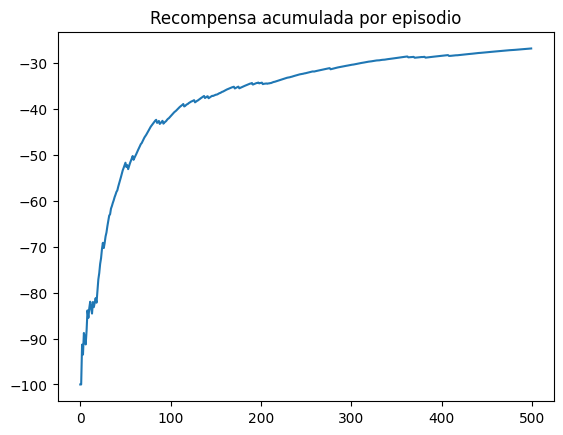

In [13]:
plot_reward_per_episode(reward_ep)

Veamos pasos por episodio

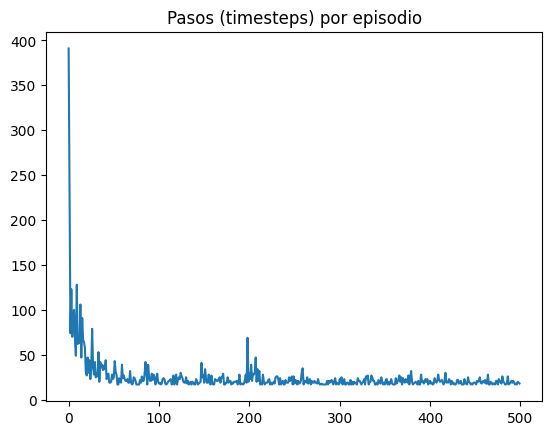

In [14]:
plot_steps_per_episode(timesteps_ep)

Suavizando...

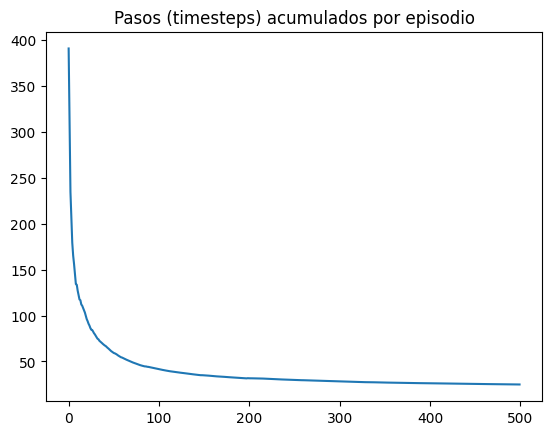

In [15]:
plot_steps_per_episode_smooth(timesteps_ep)

#### Análisis de matriz de acción-valor y política óptima

Siendo que este es un ejemplo tabular y de pocos estados / acciones, es posible realizar un análisis de convergencia desde otro punto de vista: desde el valor de la función $Q(s,a)$ para la mejor acción de cada estado, al finalizar el entrenamiento del agente, (sería la acción que el agente ejecutaría en cada estado bajo una política *greedy*). Ambos nos brindarán información sobre la convergencia alcanzada por el agente.

Tener en cuenta que este análisis se hace principalmente con fines educativos, para entornos más complejos el mismo puede no ser factible. En tales casos, un análisis alternativo podría consistir en hacer que el agente ejecute su política para la que fue entrenado, para hacer una evaluación a partir del comportamiento del mismo (esto último sería el *test de la política*, frente al *entrenamiento de la política* previo).

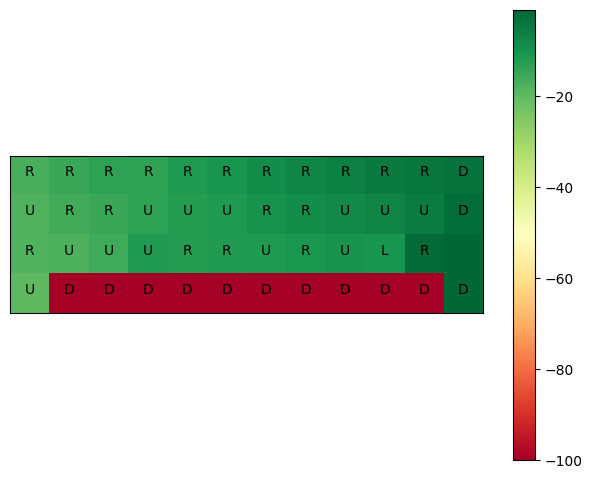


 Matriz de mejor acción-valor (en números): 

 [[ -17.23954428  -15.14316652  -13.47940719  -13.86734791  -11.50591433
   -10.42824021   -8.92910114   -7.36906975   -6.09772006   -5.02260286
    -4.246717     -3.48743802]
 [ -18.17688817  -16.29163152  -15.09887514  -13.57191616  -12.57200446
   -11.46204211  -10.28051994   -8.75636874   -8.02140089   -7.17268501
    -5.41325753   -2.24362335]
 [ -18.16818774  -17.96726471  -16.02741607  -12.12753358  -12.36502775
   -11.94064567  -11.56233996  -10.96253903   -9.96154144  -10.28531687
    -2.00258599   -1.        ]
 [ -19.72790699 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


In [16]:
draw_value_matrix(q)

In [17]:
env.close()

# Analisis comparativo distintos métodos (EJERCICIO 2 con yapa)

Definimos los hiperparámetros e instanciamos el agente para cada combinación de método de aprendizaje y de elección de acción.

In [18]:
# definimos sus híper-parámetros básicos
hyperparameters = {
    "alpha": 0.5,
    "gamma": 1,
    "epsilon": 0.1,
    "tau": 25,
}
episodes_to_run = 500
env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)


results = []
metodos = [
    ("SARSA - e-greedy", learn_SARSA, choose_action_e_greedy),
    ("SARSA - Softmax", learn_SARSA, choose_action_softmax),
    ("Q_learning - e-greedy", learn_Q_learning, choose_action_e_greedy),
    ("Q_learning - Softmax",learn_Q_learning, choose_action_softmax),
]

for name, learning_function, choose_action in metodos:

  q = {}
  avg_steps_per_episode, timesteps_ep, reward_ep = run(
    choose_action,
    learning_function,
    hyperparameters,
    episodes_to_run,
    env,
    actions,
    q,
    random_state
  )
  results = results + [(name, avg_steps_per_episode, timesteps_ep, reward_ep)]

env.close()

Modelo: SARSA - e-greedy
Average steps per episode: -26.918
Modelo: SARSA - Softmax
Average steps per episode: -19.982
Modelo: Q_learning - e-greedy
Average steps per episode: -39.746
Modelo: Q_learning - Softmax
Average steps per episode: -26.374


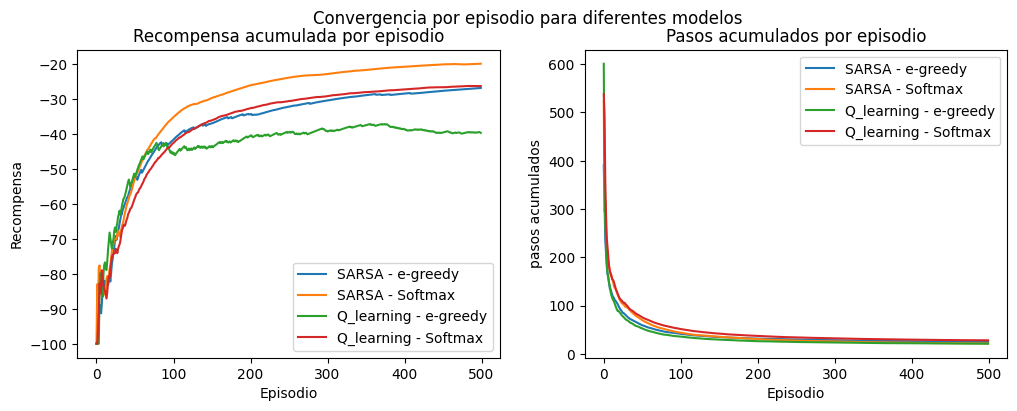

In [19]:
cols = 2

fig, axes = plt.subplots(1, cols, figsize=(12, 4))
fig.suptitle("Convergencia por episodio para diferentes modelos")

for name, avg_steps_per_episode, timesteps_ep, reward_ep in results:
  print("Modelo:", name)
  print("Average steps per episode:", avg_steps_per_episode)

  # la función f_reward_per_episode se definio en la sección anterior
  axes[0].plot(f_reward_per_episode(reward_ep), label=name)
  axes[1].plot(f_steps_per_episode_smooth(timesteps_ep), label=name)


axes[0].set_title("Recompensa acumulada por episodio")
axes[0].set_xlabel("Episodio")
axes[0].set_ylabel("Recompensa")
axes[0].legend()

axes[1].set_title("Pasos acumulados por episodio")
axes[1].set_xlabel("Episodio")
axes[1].set_ylabel("pasos acumulados")
axes[1].legend()

plt.show()

### Convergencia

Generalmente, Q-Learning puede converger más rápidamente que SARSA porque es un algoritmo off-policy. Esto significa que Q-Learning actualiza sus valores Q basándose en las mejores acciones posibles, mientras que SARSA actualiza los valores basándose en las acciones que realmente se toman (que pueden ser subóptimas).

Exploración vs. Explotación: La manera en que manejan la exploración y la explotación puede también influir en la velocidad de convergencia. Ajustar el valor de epsilon puede ser clave en la convergencia de ambos métodos.

# Análisis comparativo con distintos parámetros (EJERCICIO 3)

## Análisis de alpha

In [20]:

episodes_to_run = 500
env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

h_alphas = [0.1, 0.3, 0.5]

# se puede cambiar por learn_Q_learning, una vez que se implemente
learning_function = learn_SARSA # learn_Q_learning #

choose_action = choose_action_e_greedy #choose_action_softmax
episodes_to_run = 500

results_alpha = []

for alpha in h_alphas:
  # definimos sus híper-parámetros básicos
  hyperparameters = {
    "alpha": alpha,
    "gamma": 1,
    "epsilon": 0.1,
    "tau": 25,
  }
  q = {}

  avg_steps_per_episode, timesteps_ep, reward_ep = run(
    choose_action,
    learning_function,
    hyperparameters,
    episodes_to_run,
    env,
    actions,
    q,
    random_state
  )
  results_alpha = results_alpha + [(alpha, avg_steps_per_episode, timesteps_ep, reward_ep)]

env.close()

Alpha: 0.1
Average steps per episode: -36.234
Alpha: 0.3
Average steps per episode: -27.984
Alpha: 0.5
Average steps per episode: -26.968


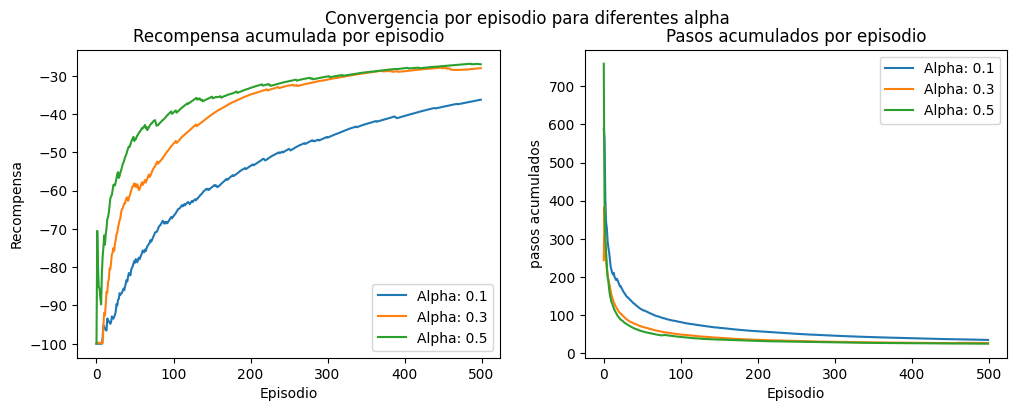

In [21]:
cols = 2

fig, axes = plt.subplots(1, cols, figsize=(12, 4))
fig.suptitle("Convergencia por episodio para diferentes alpha")

for alpha, avg_steps_per_episode, timesteps_ep, reward_ep in results_alpha:
  print("Alpha:", alpha)
  print("Average steps per episode:", avg_steps_per_episode)

  # la función f_reward_per_episode se definio en la sección anterior
  axes[0].plot(f_reward_per_episode(reward_ep), label=f"Alpha: {alpha}")
  axes[1].plot(f_steps_per_episode_smooth(timesteps_ep), label=f"Alpha: {alpha}")


axes[0].set_title("Recompensa acumulada por episodio")
axes[0].set_xlabel("Episodio")
axes[0].set_ylabel("Recompensa")
axes[0].legend()

axes[1].set_title("Pasos acumulados por episodio")
axes[1].set_xlabel("Episodio")
axes[1].set_ylabel("pasos acumulados")
axes[1].legend()

plt.show()



Se observa que los alphas mas pequeños convergen más lento. Esto es razonable, ya que el alpha nos indica el peso que le damos a las predicciones cuando actualizamos el q.

## Análisis de gamma

In [22]:
episodes_to_run = 500
env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

h_gammas = [0.8, 0.9, 0.95, 1]

# se puede cambiar por learn_Q_learning, una vez que se implemente
learning_function = learn_SARSA # learn_Q_learning #

choose_action = choose_action_e_greedy #choose_action_softmax
episodes_to_run = 500

results_gamma = []

for gamma in h_gammas:
  # definimos sus híper-parámetros básicos
  hyperparameters = {
    "alpha": 0.5,
    "gamma": gamma,
    "epsilon": 0.1,
    "tau": 25,
  }
  q = {}

  avg_steps_per_episode, timesteps_ep, reward_ep = run(
    choose_action,
    learning_function,
    hyperparameters,
    episodes_to_run,
    env,
    actions,
    q,
    random_state
  )
  results_gamma = results_gamma + [(gamma, avg_steps_per_episode, timesteps_ep, reward_ep)]

env.close()

Gamma: 0.8
Average steps per episode: -43.978
Gamma: 0.9
Average steps per episode: -32.512
Gamma: 0.95
Average steps per episode: -30.936
Gamma: 1
Average steps per episode: -27.804


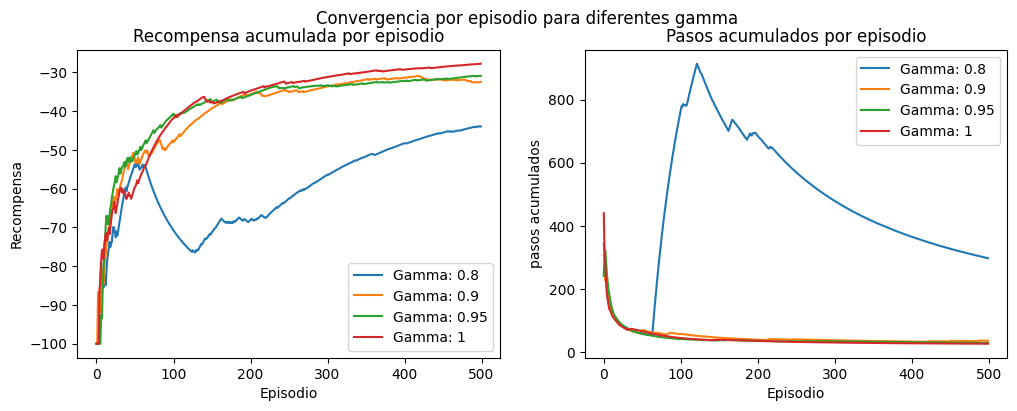

In [23]:
cols = 2

fig, axes = plt.subplots(1, cols, figsize=(12, 4))
fig.suptitle("Convergencia por episodio para diferentes gamma")

for gamma, avg_steps_per_episode, timesteps_ep, reward_ep in results_gamma:
  print("Gamma:", gamma)
  print("Average steps per episode:", avg_steps_per_episode)

  # la función f_reward_per_episode se definio en la sección anterior
  axes[0].plot(f_reward_per_episode(reward_ep), label=f"Gamma: {gamma}")
  axes[1].plot(f_steps_per_episode_smooth(timesteps_ep), label=f"Gamma: {gamma}")


axes[0].set_title("Recompensa acumulada por episodio")
axes[0].set_xlabel("Episodio")
axes[0].set_ylabel("Recompensa")
axes[0].legend()

axes[1].set_title("Pasos acumulados por episodio")
axes[1].set_xlabel("Episodio")
axes[1].set_ylabel("pasos acumulados")
axes[1].legend()

plt.show()

Se observa que en general se prefiere un gamma entre 0.9 y 1. Cuando tomamos un gamma mayor (más cerca de 1) utilizamos con mayor peso los q del próximo paso.
De todas maneras, este gamma afectará diferente a SARSA que a Q_learning.


## Análisis de epsilon

In [24]:
episodes_to_run = 500
env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

h_epsilons = [0.01, 0.1, 0.2]

# se puede cambiar por learn_Q_learning, una vez que se implemente
learning_function = learn_SARSA # learn_Q_learning #

choose_action = choose_action_e_greedy #choose_action_softmax
episodes_to_run = 500

results_epsilon = []

for epsilon in h_epsilons:
  # definimos sus híper-parámetros básicos
  hyperparameters = {
    "alpha": 0.5,
    "gamma": 1,
    "epsilon": epsilon,
    "tau": 25,
  }
  q = {}

  avg_steps_per_episode, timesteps_ep, reward_ep = run(
    choose_action,
    learning_function,
    hyperparameters,
    episodes_to_run,
    env,
    actions,
    q,
    random_state
  )
  results_epsilon = results_epsilon + [(epsilon, avg_steps_per_episode, timesteps_ep, reward_ep)]

env.close()

Espsilon: 0.01
Average steps per episode: -18.946
Espsilon: 0.1
Average steps per episode: -30.964
Espsilon: 0.2
Average steps per episode: -38.78


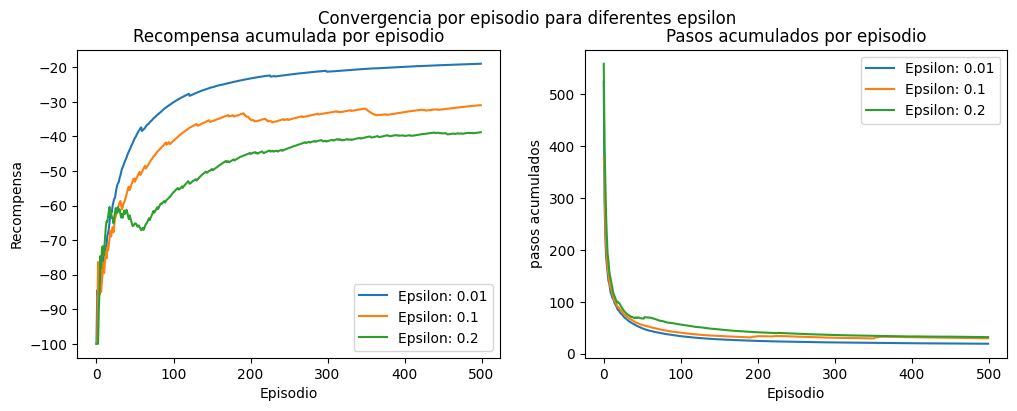

In [25]:
cols = 2

fig, axes = plt.subplots(1, cols, figsize=(12, 4))
fig.suptitle("Convergencia por episodio para diferentes epsilon")

for epsilon, avg_steps_per_episode, timesteps_ep, reward_ep in results_epsilon:
  print("Espsilon:", epsilon)
  print("Average steps per episode:", avg_steps_per_episode)

  # la función f_reward_per_episode se definio en la sección anterior
  axes[0].plot(f_reward_per_episode(reward_ep), label=f"Epsilon: {epsilon}")
  axes[1].plot(f_steps_per_episode_smooth(timesteps_ep), label=f"Epsilon: {epsilon}")


axes[0].set_title("Recompensa acumulada por episodio")
axes[0].set_xlabel("Episodio")
axes[0].set_ylabel("Recompensa")
axes[0].legend()

axes[1].set_title("Pasos acumulados por episodio")
axes[1].set_xlabel("Episodio")
axes[1].set_ylabel("pasos acumulados")
axes[1].legend()

plt.show()

A partir de un epsilon más pequeño se obtiene una convergencia más pronunciada cuando trabajamos con el algoritmo de selección de acciones $\epsilon$-greedy. Esto es razonable ya que el epsilon es la probabilidad de elegir un camino que no sea el óptimo. De todas maneras, elegir un epsilon muy pequeño hace que el agente demore más en detectar cambios en el modelo. Por lo que nuestra elección depende de cuánto varíe el modelo en el tiempo.

# Actividades

1. Implementar y ejecutar el algoritmo SARSA en "The Cliff".

**OK**

2. Implementar y ejecutar el algoritmo Q-Learning en "The Cliff". ¿Cómo converge con respecto a SARSA? ¿A qué se debe? Comentar.

**OK**

3. Ejecutando con distintos híper-parámetros, realizar una breve descripción sobre cómo afectan a la convergencia los distintos valores de $\alpha$ , $\epsilon$ y $\gamma$ .

**OK**

4. (Opcional) Implementar política de exploración Softmax, en donde cada acción tiene una probabilidad $$\pi(a \mid s) = \frac{e^{Q(s,a)/\tau}}{\sum_{\widetilde{a} \in A}e^{Q(s,\widetilde{a})/\tau}}$$

**OK**

5. (Opcional) Implementar Dyna-Q a partir del algoritmo Q-Learning, incorporando una actualización mediante un modelo. Comentar cómo se desempeña respecto a los demás algoritmos.


Para dejar el lab listo para su corrección, dejar link a repo de Github con un notebook ejecutando el agente en la planilla enviada en Slack.

FIN